# Arrival Time Challenge

In [177]:
import pandas as pd
import numpy as np

In [178]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load data

In [179]:
orders = pd.read_csv('data/orders.csv')
order_product = pd.read_csv('data/order_product.csv')
shoppers = pd.read_csv('data/shoppers.csv')
storebranch = pd.read_csv('data/storebranch.csv')

In [180]:
orders.head()

,order_id,lat,lng,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes
0,6abd5e28d01b7c733fe37485294235dc,18.221141,-100.313914,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861
1,0d37a1eea001f01b40232ffd496ff663,18.177712,-100.357051,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732
2,528428e9b9eb5d3bd0dbdd8da692b087,18.266832,-100.317553,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001
3,d3f7be6d64eae7405b7bf024e04807a2,18.248884,-100.322622,2,10:00:00,09:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761
4,e0ad6533b6cd9a382ec6c1d473c5036c,18.229110,-100.322672,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208


### Extract and Join data
Extract and join the features (columns) of the tables that seem relevant to me for the business according to my sense of smell.

In [181]:
orders.columns

Index(['order_id', 'lat', 'lng', 'dow', 'promised_time', 'actual_time',
       'on_demand', 'picker_id', 'driver_id', 'store_branch_id',
       'total_minutes'],
      dtype='object')

Drop features that are not very promising (at the moment).

In [182]:
orders.drop(['lat', 'lng'], axis=1, inplace=True)

#### Join *order_product* table

In [183]:
print("Num orders in orders: " ,len(orders['order_id'].unique()))
print("Num orders in order_product: " ,len(order_product['order_id'].unique()))

Num orders in orders:  7295
Num orders in order_product:  7278


*There are elements in the orders table that are not in the order_product table.*

In [184]:
order_product.columns

Index(['order_id', 'product_id', 'quantity', 'quantity_found', 'buy_unit'], dtype='object')

They will be discarded so as not to compute the grouping operations on these columns.

In [185]:
order_product.drop(['product_id', 'quantity_found', 'buy_unit'], axis=1, inplace=True)

I think the amount of different products will be a good feature. Idem with the sum of all the products.

In [186]:
products = order_product.groupby('order_id').agg([np.size, np.sum])['quantity']

In [187]:
## Convert order_id index to column for merge operation
products.reset_index(inplace=True)

In [188]:
products.rename(columns={'size': 'quantity_products', 'sum': 'sum_products'}, inplace=True)

Matrix will be the union of "relevant" features of different tables.

In [189]:
matrix = pd.merge(orders, products, on='order_id')

In [190]:
matrix.head()

,order_id,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,quantity_products,sum_products
0,6abd5e28d01b7c733fe37485294235dc,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861,27.0,24.722
1,0d37a1eea001f01b40232ffd496ff663,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,103.0,189.562
2,528428e9b9eb5d3bd0dbdd8da692b087,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,6.0,6.000
3,d3f7be6d64eae7405b7bf024e04807a2,2,10:00:00,09:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761,17.0,38.300
4,e0ad6533b6cd9a382ec6c1d473c5036c,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,44.0,38.721


#### Join *shopper* table

In [191]:
shoppers.columns

Index(['shopper_id', 'seniority', 'found_rate', 'picking_speed',
       'accepted_rate', 'rating'],
      dtype='object')

In [192]:
shoppers.drop(['found_rate', 'picking_speed', 'accepted_rate'], axis=1, inplace=True)

In [193]:
shoppers.head()

,shopper_id,seniority,rating
0,087ab65ceca40dbef697f585dc159d5d,ADVANCED,4.48
1,645973c41314d763b58dc2bceeeeffc9,INTERMEDIATE,4.79
2,82810715fdda44962e7e422015ea1f32,ADVANCED,4.84
3,416aa7dbd5a2f58d7bca96657e8faa1e,INTERMEDIATE,NaN
4,27a3e845a4c3eb7ded4748f84140a843,ADVANCED,4.84


Text(0.5,1,'Missing values')

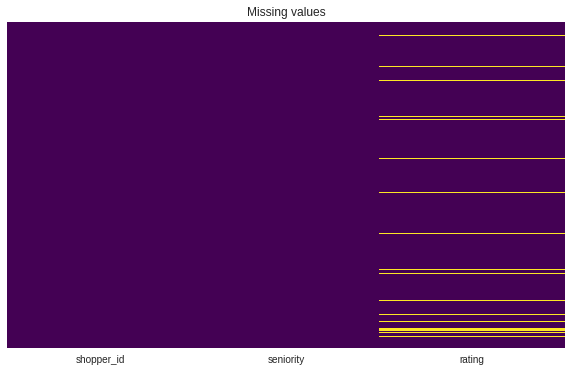

In [194]:
## Identify missing values
plt.figure(figsize=(10, 6))
sns.heatmap(shoppers.isnull(), yticklabels=False, cbar=False, cmap='viridis').set_title('Missing values')

Replace the null values of the rating column with the mean of the seniority group to which it belongs.

In [195]:
shoppers['rating'] = shoppers.groupby('seniority').transform(lambda x: x.fillna(x.mean()))

In [196]:
## Join picker data
matrix = pd.merge(matrix, shoppers, how='left', left_on=['picker_id'], right_on=['shopper_id'])

In [197]:
## Join driver data
matrix = pd.merge(matrix, shoppers, how='left', left_on=['driver_id'], right_on=['shopper_id'])

In [198]:
matrix.columns

Index(['order_id', 'dow', 'promised_time', 'actual_time', 'on_demand',
       'picker_id', 'driver_id', 'store_branch_id', 'total_minutes',
       'quantity_products', 'sum_products', 'shopper_id_x', 'seniority_x',
       'rating_x', 'shopper_id_y', 'seniority_y', 'rating_y'],
      dtype='object')

In [199]:
matrix.drop(['shopper_id_x', 'shopper_id_y'], axis=1, inplace=True)

In [200]:
matrix.rename(columns={'seniority_x': 'picker_seniority', 
                       'rating_x': 'picker_rating',
                       'seniority_y': 'driver_seniority',
                       'rating_y': 'driver_rating'}, inplace=True)

In [201]:
matrix.head()

,order_id,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes,quantity_products,sum_products,picker_seniority,picker_rating,driver_seniority,driver_rating
0,6abd5e28d01b7c733fe37485294235dc,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800861,27.0,24.722,ADVANCED,4.68,ADVANCED,4.68
1,0d37a1eea001f01b40232ffd496ff663,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599732,103.0,189.562,ADVANCED,4.76,ADVANCED,4.76
2,528428e9b9eb5d3bd0dbdd8da692b087,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458001,6.0,6.000,INTERMEDIATE,4.96,INTERMEDIATE,4.96
3,d3f7be6d64eae7405b7bf024e04807a2,2,10:00:00,09:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778761,17.0,38.300,INTERMEDIATE,4.92,INTERMEDIATE,4.92
4,e0ad6533b6cd9a382ec6c1d473c5036c,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321208,44.0,38.721,ADVANCED,4.92,ADVANCED,4.92


#### Join *storebranch* table

In [202]:
storebranch.columns

Index(['store_branch_id', 'store', 'lat', 'lng'], dtype='object')

In [203]:
storebranch.drop(['lat', 'lng'], axis=1, inplace=True)

In [204]:
matrix = pd.merge(matrix, storebranch, on='store_branch_id')

In [205]:
matrix.drop(['picker_id', 'driver_id', 'store_branch_id'], axis=1, inplace=True)

In [206]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7278 entries, 0 to 7277
Data columns (total 13 columns):
order_id             7278 non-null object
dow                  7278 non-null int64
promised_time        7278 non-null object
actual_time          7278 non-null object
on_demand            7278 non-null bool
total_minutes        6528 non-null float64
quantity_products    7278 non-null float64
sum_products         7278 non-null float64
picker_seniority     7278 non-null object
picker_rating        7278 non-null float64
driver_seniority     7278 non-null object
driver_rating        7278 non-null float64
store                7278 non-null object
dtypes: bool(1), float64(5), int64(1), object(6)
memory usage: 746.3+ KB


### Prepare Data
#### Prepare time data

In [207]:
from datetime import timedelta
def time2int(time):
    """
    Convert time in format hhmmss to integer.
    """
    (h, m, s) = time.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

*total_time*: Total time to complete the order in seconds. **Corresponds to the variable to predict.**

In [208]:
# Convert minutes to seconds
matrix['total_time'] = matrix['total_minutes'].apply(
    lambda x: timedelta(minutes=x).total_seconds() if(np.all(pd.notnull(x))) else x)  

*actual_time*: Time when the order was delivered to the customer.

In [209]:
matrix['actual_time'] = matrix['actual_time'].apply(time2int)

*promised_time*: Delivery time promised to the customer.

In [210]:
matrix['promised_time'] = matrix['promised_time'].apply(time2int)

In [211]:
matrix.columns

Index(['order_id', 'dow', 'promised_time', 'actual_time', 'on_demand',
       'total_minutes', 'quantity_products', 'sum_products',
       'picker_seniority', 'picker_rating', 'driver_seniority',
       'driver_rating', 'store', 'total_time'],
      dtype='object')

### Exploratory Data Analysis

In [212]:
matrix.head()

,order_id,dow,promised_time,actual_time,on_demand,total_minutes,quantity_products,sum_products,picker_seniority,picker_rating,driver_seniority,driver_rating,store,total_time
0,6abd5e28d01b7c733fe37485294235dc,2,46800,43215,False,91.800861,27.0,24.722,ADVANCED,4.68,ADVANCED,4.68,60e4c4e1c1a8bc79123738227b9d0b08,5508.05166
1,d3f7be6d64eae7405b7bf024e04807a2,2,36000,34907,False,124.778761,17.0,38.300,INTERMEDIATE,4.92,INTERMEDIATE,4.92,60e4c4e1c1a8bc79123738227b9d0b08,7486.72566
2,ba8444278cc2535fdc9febc9cf5b8cd1,2,39600,34689,False,84.696572,32.0,30.411,ADVANCED,4.88,ADVANCED,4.88,60e4c4e1c1a8bc79123738227b9d0b08,5081.79432
3,779d38a1e11e84b90d79d8a16f5f38a8,2,46800,42788,False,80.875581,24.0,35.100,ADVANCED,4.92,ADVANCED,4.92,60e4c4e1c1a8bc79123738227b9d0b08,4852.53486
4,d4c3721b582a43b13c4d6c8e0667c88a,2,36000,32854,False,126.207238,40.0,63.399,ADVANCED,4.84,ADVANCED,4.84,60e4c4e1c1a8bc79123738227b9d0b08,7572.43428


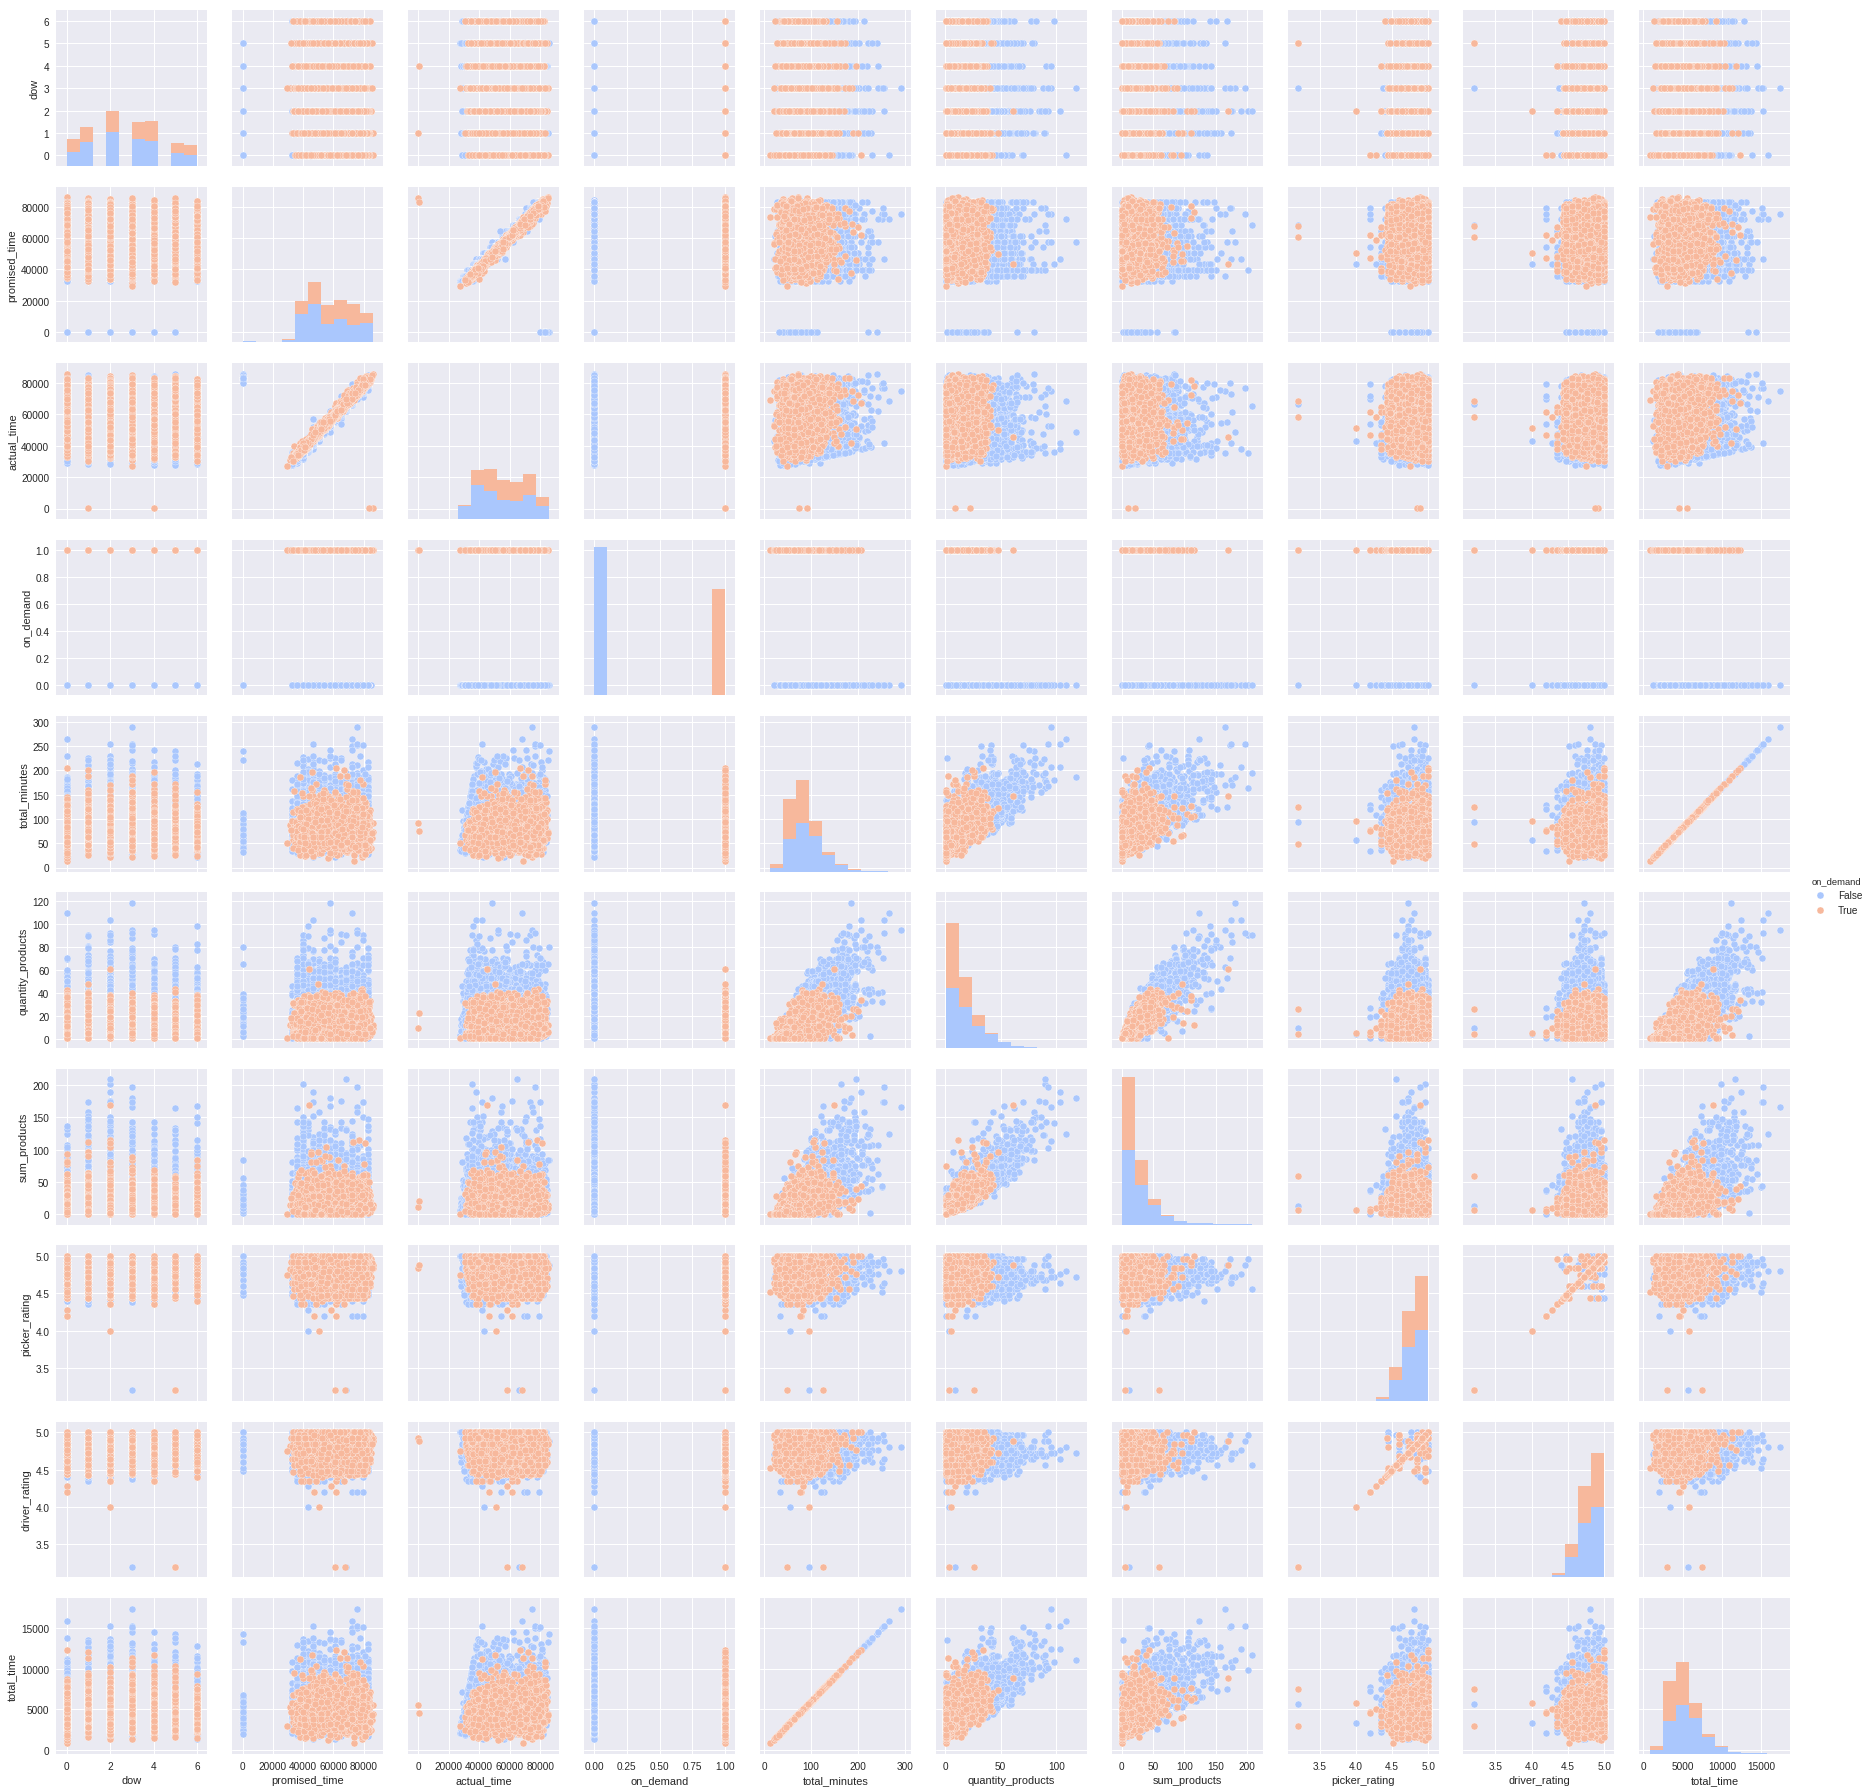

In [213]:
sns.pairplot(matrix[matrix['total_minutes'].isnull() == False], hue='on_demand',palette='coolwarm')

[Text(0.5,0,'dow'),
 Text(1.5,0,'promised_time'),
 Text(2.5,0,'actual_time'),
 Text(3.5,0,'on_demand'),
 Text(4.5,0,'total_minutes'),
 Text(5.5,0,'quantity_products'),
 Text(6.5,0,'sum_products'),
 Text(7.5,0,'picker_rating'),
 Text(8.5,0,'driver_rating'),
 Text(9.5,0,'total_time')]

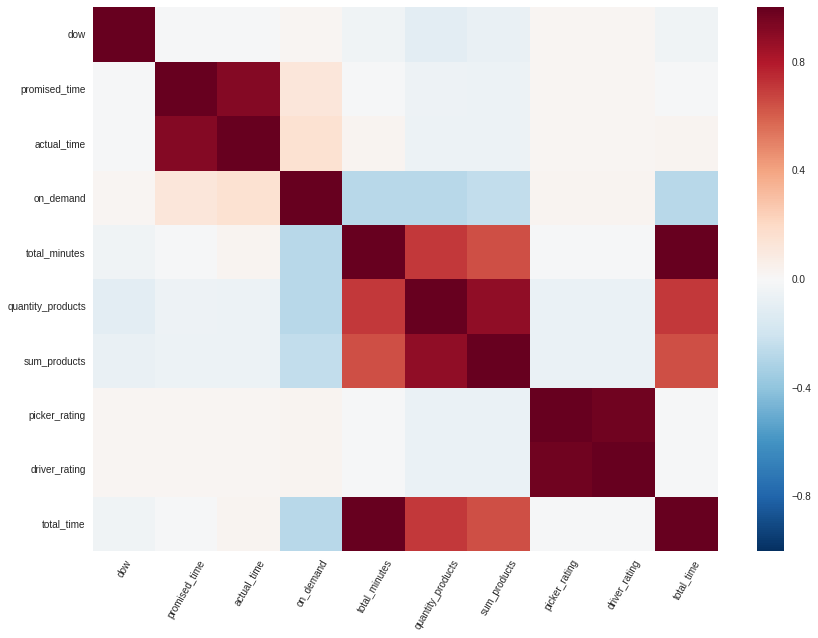

In [215]:
plt.figure(figsize=(14, 10))
heatmap_corr = sns.heatmap(matrix.corr())
heatmap_corr.set_xticklabels(heatmap_corr.get_xticklabels(), rotation=60)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


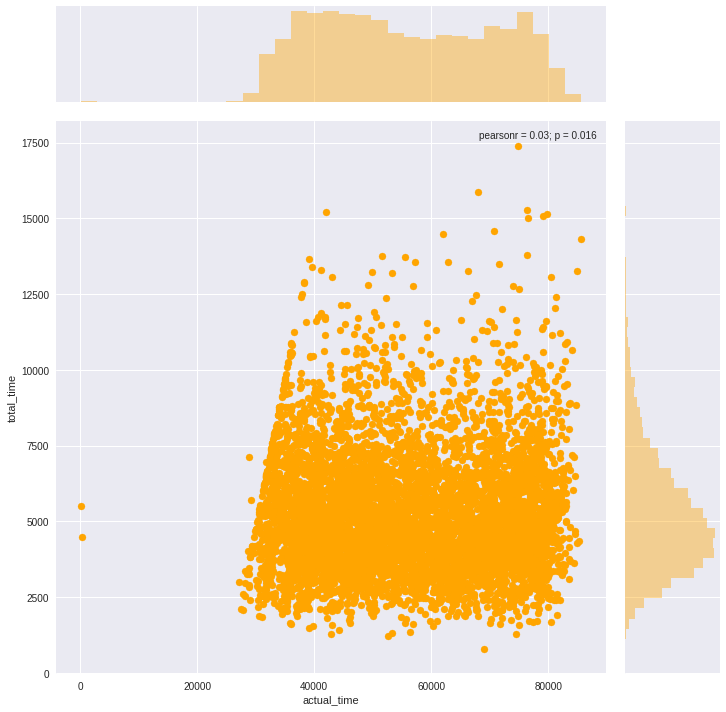

In [216]:
sns.jointplot(x='actual_time',y='total_time',data=matrix, size=10, color='orange')

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


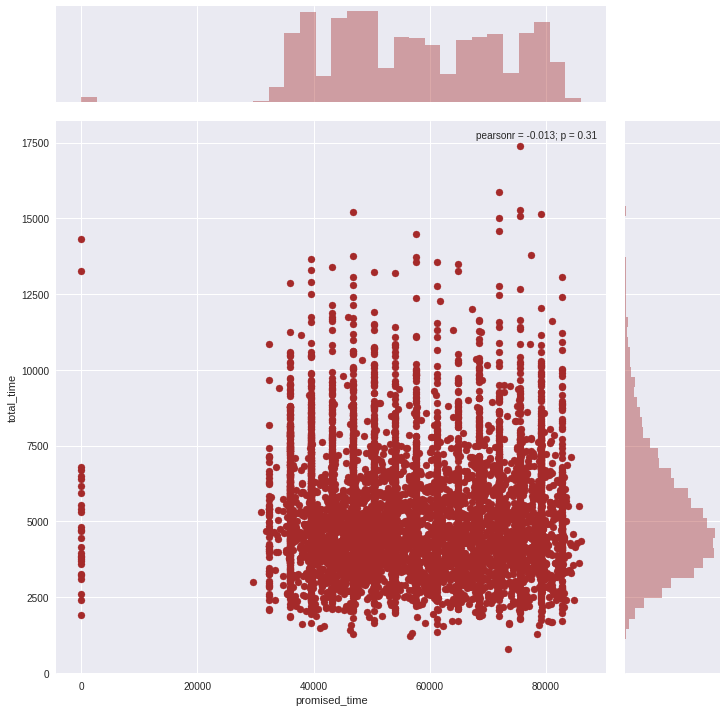

In [217]:
sns.jointplot(x='promised_time',y='total_time',data=matrix, size=10, color='brown')

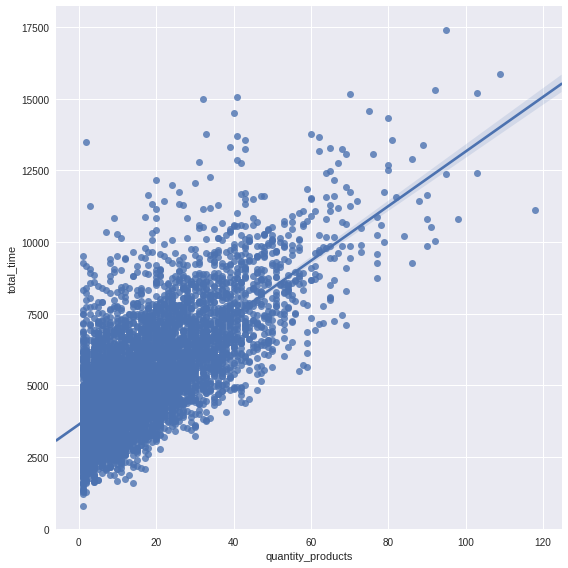

In [218]:
sns.lmplot(x='quantity_products',y='total_time', data=matrix, size=8)

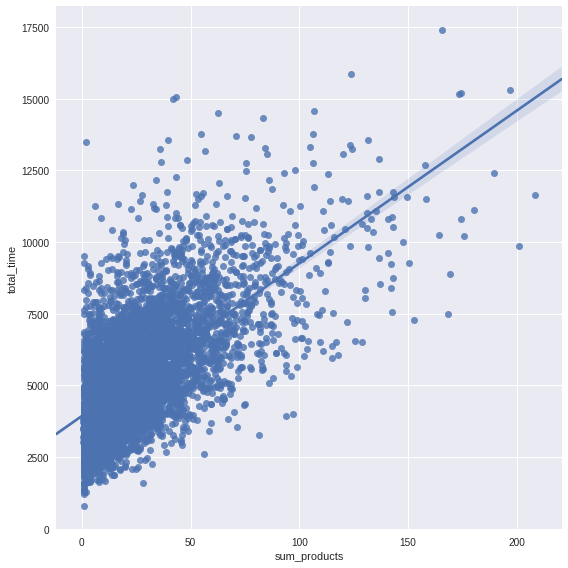

In [219]:
sns.lmplot(x='sum_products',y='total_time', data=matrix, size=8)

[Text(0,0,'60e4c4e1c1a8bc79123738227b9d0b08'),
 Text(0,0,'387d4a5b65cf4bf00ad805c4b00eed01'),
 Text(0,0,'0fae7b61265bc7ca4ce4d81440b62501'),
 Text(0,0,'452ae015bf846e1d2932b7ea15720d64'),
 Text(0,0,'044d56734d20e04984d846dade6d39f3'),
 Text(0,0,'451eb58b96f0a36f31d2beebd1c9a7a8'),
 Text(0,0,'e27789d5e619b255663b2bfa68b5851f'),
 Text(0,0,'9d65282d498c0338377867996e761399'),
 Text(0,0,'6447951cd071f6f045fd4e6194920926'),
 Text(0,0,'a3bed30221372366bcd9b9779f395d0b'),
 Text(0,0,'0b0d1b4d525596dc61c3fde64a6bf099'),
 Text(0,0,'6dd84f26df649bead537d40ec49afd36'),
 Text(0,0,'c0b93cf93cf854981b8d6bd849eec4b0'),
 Text(0,0,'a08814af6c2379a480e261b3598ddbd5'),
 Text(0,0,'821dc9d74061fe7654b9ec20e574022d'),
 Text(0,0,'7a44728dc60bafc53140a9f5ef7e4e75'),
 Text(0,0,'1174a0029cadfa449af46c53b1c90fbe')]

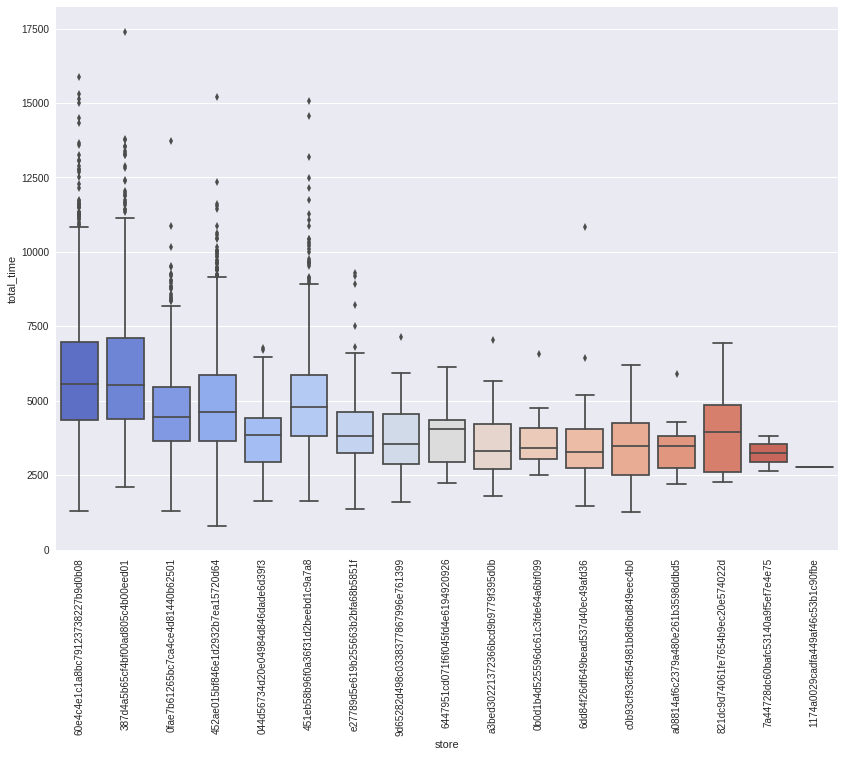

In [220]:
plt.figure(figsize=(14, 10))
box_stores = sns.boxplot(x='store',y='total_time', data=matrix, palette='coolwarm')
box_stores.set_xticklabels(box_stores.get_xticklabels(), rotation=90)

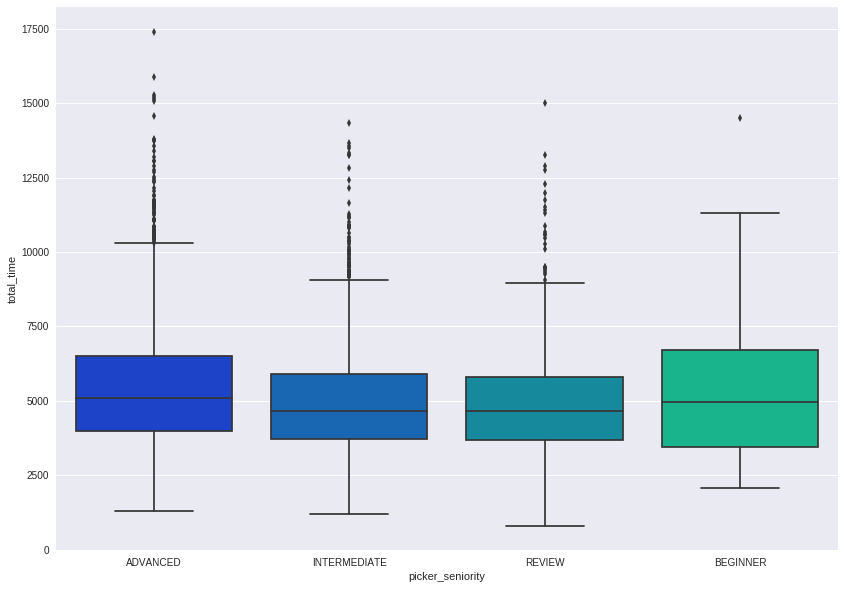

In [221]:
plt.figure(figsize=(14, 10))
sns.boxplot(x='picker_seniority',y='total_time',data=matrix, palette='winter')

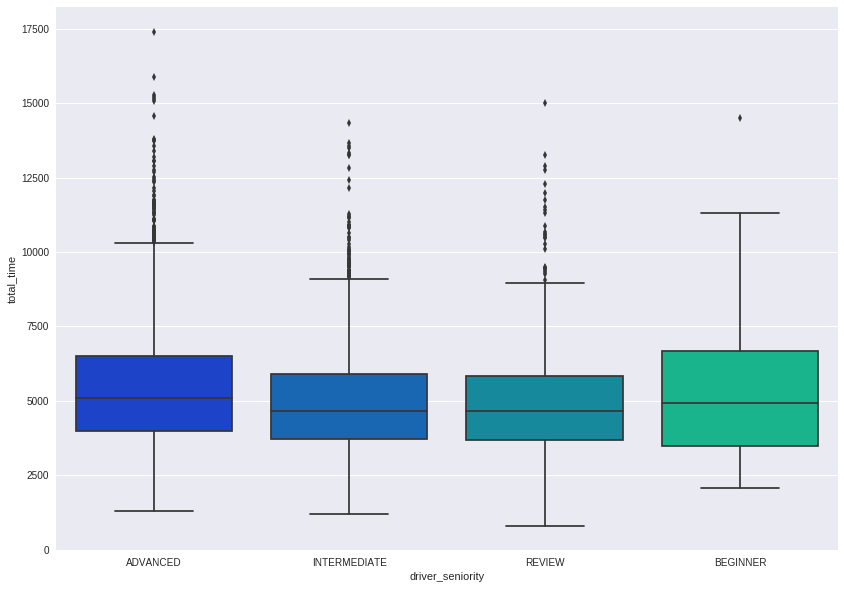

In [222]:
plt.figure(figsize=(14, 10))
sns.boxplot(x='driver_seniority',y='total_time',data=matrix, palette='winter')

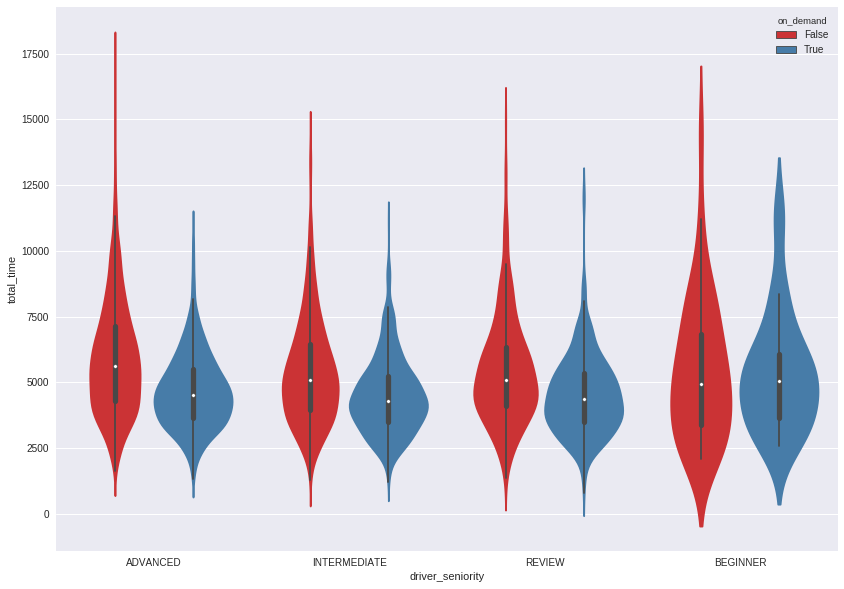

In [223]:
plt.figure(figsize=(14, 10))
sns.violinplot(x="driver_seniority", y="total_time", data=matrix, hue='on_demand',palette='Set1')

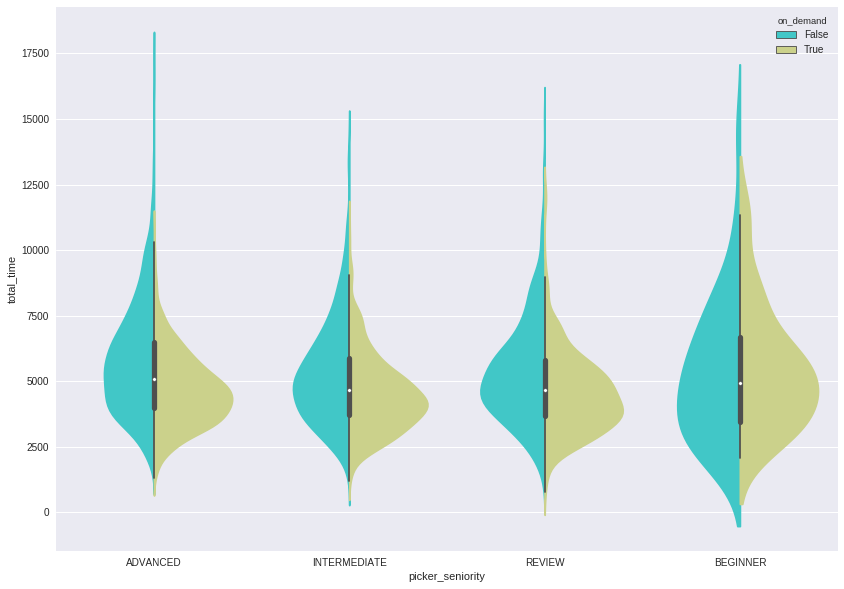

In [224]:
plt.figure(figsize=(14, 10))
sns.violinplot(x="picker_seniority", y="total_time", data=matrix, split=True, hue='on_demand',palette='rainbow')

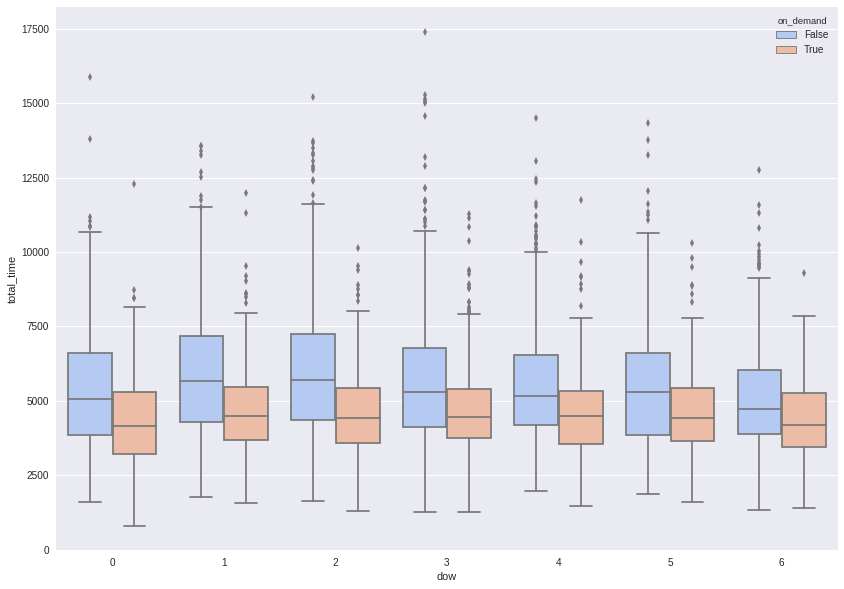

In [225]:
plt.figure(figsize=(14, 10))
sns.boxplot(x="dow", y="total_time", hue="on_demand",data=matrix, palette="coolwarm")

#### Preliminary analysis
It seems that it does not matter much the day in which the order is made, since all of them present a similar behavior with respect to delivery times. Neither does it seem to be an influential variable neither the buyers nor at the moment in which an order enters the platform. Apparently, the features that have more relation with the time used are: the quantity of products, on_demand and the store.

## Building a Machine Learning Pipeline

In this section, different machine learning algorithms will be used in different conditions. These conditions will be based on:
- The features used
- Technique applied to categorical variables
- Portion of training and test data

### Converting Categorical Features 

In [229]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Encoding *on_demand* 

In [230]:
matrix['on_demand'] = pd.get_dummies(matrix['on_demand'], drop_first=True)

Apply One-Hot Encoder

In [231]:
od_le = LabelEncoder()
od_labels = od_le.fit_transform(matrix['on_demand'])
matrix['on_demand'] = od_labels

od_ohe = OneHotEncoder()
od_feature_arr = od_ohe.fit_transform(matrix[['on_demand']]).toarray()
od_feature_labels = ['ondemand_'+str(od_label) for od_label in od_le.classes_]
od_feature = pd.DataFrame(od_feature_arr, columns=od_feature_labels)

Encoding *stores* 

In [232]:
stores = pd.get_dummies(matrix['store'])
## Rename columns
stores.columns = ['store_'+str(e) for e in list(range(1, len(stores.columns) + 1))]
matrix = pd.concat([matrix, stores], axis=1)

Encoding *dow* 

In [233]:
dow = pd.get_dummies(matrix['dow'], drop_first=True)
dow.columns = ['dow_'+str(col_name) for col_name in dow.columns]
matrix = pd.concat([matrix, dow], axis=1)

Encoding *picker_seniority*

In [234]:
picker = pd.get_dummies(matrix['picker_seniority'], drop_first=True)
picker.columns = ['picker_'+col_name.lower() for col_name in picker.columns]
matrix = pd.concat([matrix, picker], axis=1)

Encoding *driver_seniority*

In [235]:
driver = pd.get_dummies(matrix['driver_seniority'], drop_first=True)
driver.columns = ['driver_'+col_name.lower() for col_name in driver.columns]
matrix = pd.concat([matrix, driver], axis=1)

In [236]:
## Drop other columns
matrix.drop(['store', 'order_id', 'dow', 'picker_seniority', 
             'driver_seniority'], axis=1, inplace=True)
matrix.head()

,promised_time,actual_time,on_demand,total_minutes,quantity_products,sum_products,picker_rating,driver_rating,total_time,store_1,...,dow_3,dow_4,dow_5,dow_6,picker_beginner,picker_intermediate,picker_review,driver_beginner,driver_intermediate,driver_review
0,46800,43215,0,91.800861,27.0,24.722,4.68,4.68,5508.05166,0,...,0,0,0,0,0,0,0,0,0,0
1,36000,34907,0,124.778761,17.0,38.300,4.92,4.92,7486.72566,0,...,0,0,0,0,0,1,0,0,1,0
2,39600,34689,0,84.696572,32.0,30.411,4.88,4.88,5081.79432,0,...,0,0,0,0,0,0,0,0,0,0
3,46800,42788,0,80.875581,24.0,35.100,4.92,4.92,4852.53486,0,...,0,0,0,0,0,0,0,0,0,0
4,36000,32854,0,126.207238,40.0,63.399,4.84,4.84,7572.43428,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
matrix.columns

Index(['promised_time', 'actual_time', 'on_demand', 'total_minutes',
       'quantity_products', 'sum_products', 'picker_rating', 'driver_rating',
       'total_time', 'store_1', 'store_2', 'store_3', 'store_4', 'store_5',
       'store_6', 'store_7', 'store_8', 'store_9', 'store_10', 'store_11',
       'store_12', 'store_13', 'store_14', 'store_15', 'store_16', 'store_17',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review'],
      dtype='object')

### Process missing values

Text(0.5,1,'Missing values')

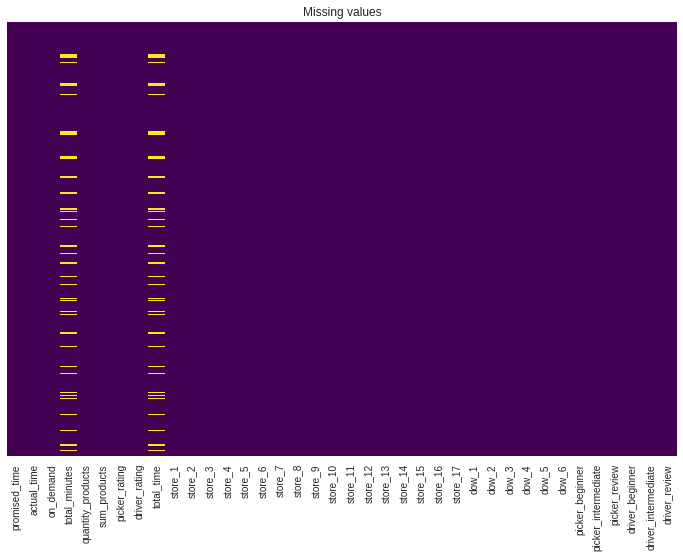

In [239]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix.isnull(), yticklabels=False, cbar=False, cmap='viridis').set_title('Missing values')

Only missing data related to the field 'total_minutes'. As the objective is to complete this field that are empty, the dataset will be divided according to this criterion.

In [240]:
matrix_tocomplete = matrix[matrix['total_minutes'].isnull()]
matrix = matrix[matrix['total_minutes'].isnull() == False]

In [241]:
print('{:.3f}% of the original dataset corresponds to Matrix.'.format(len(matrix) * 100 / len(orders)))

89.486% of the original dataset corresponds to Matrix.


### Regression Evaluation Metrics to Apply


Three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**. We want to minimize them.

## Running ML Algorithms

In [242]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [243]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [244]:
from sklearn import metrics

In [245]:
def run_ML_pipeline(X, y):
    """
    Run a set of Machine Learning algorithms over a dataset.
    Return the evaluation of ML algorithms.
    """
    models = []
    models.append(('Linear Regression', LinearRegression()))
    models.append(('Ridge Regression', Ridge()))
    models.append(('LASSO Regression', Lasso()))
    models.append(('ElasticNet Regression', ElasticNet()))
    models.append(('K-Nearest Neighbors', KNeighborsRegressor()))
    models.append(('Regression Trees', DecisionTreeRegressor()))
    models.append(('Support Vector Machines', SVR()))
    models.append(('Neural Net Regressor', MLPRegressor()))
    
    result_metrics = {'MAE':[], 'MSE':[], 'RMSE':[]}
    results = {'names': [], 'data': []}
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=101)
        ## Computing MAE
        cv_results = cross_val_score(model, X, y, cv=kfold, 
                                     scoring='neg_mean_absolute_error')
        result_metrics['MAE'].append((cv_results * -1).mean())
        
        ## Building plot of all MAE
        results['names'] = results['names'] + ([name] * len(cv_results))
        results['data'] = np.concatenate([results['data'], cv_results * -1])
        
        ## Computing MSE
        cv_results = cross_val_score(model, X, y, cv=kfold, 
                                     scoring='neg_mean_squared_error')
        result_metrics['MSE'].append((cv_results * -1).mean())
        result_metrics['RMSE'].append(np.sqrt((cv_results * -1).mean()))
    # boxplot algorithm comparison
    
    plt.figure(figsize=(14, 10))
    bplot_results = sns.boxplot(x="names", y="data", 
                                data=pd.DataFrame(results), palette="rainbow")
    bplot_results.set_xticklabels(bplot_results.get_xticklabels(), rotation=60)
    bplot_results.set_title('Algorithm Comparison')
    bplot_results.set_ylabel('MAE')
    bplot_results.set_xlabel('Algorithms')
    
    return pd.DataFrame(result_metrics, index=[model[0] for model in models])

In [246]:
matrix.columns

Index(['promised_time', 'actual_time', 'on_demand', 'total_minutes',
       'quantity_products', 'sum_products', 'picker_rating', 'driver_rating',
       'total_time', 'store_1', 'store_2', 'store_3', 'store_4', 'store_5',
       'store_6', 'store_7', 'store_8', 'store_9', 'store_10', 'store_11',
       'store_12', 'store_13', 'store_14', 'store_15', 'store_16', 'store_17',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review'],
      dtype='object')

### #1 features selected:
- dow
- on_demand
- actual_time
- stores

In [247]:
X = matrix[['on_demand', 'dow_1','dow_2', 'dow_3', 
            'dow_4', 'dow_5', 'dow_6', 'store_1', 'store_2', 'store_3', 
            'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 
            'store_9', 'store_10', 'store_11', 'store_12', 'store_13', 
            'store_14', 'store_15', 'store_16', 'store_17', 
            'actual_time']]
y = matrix['total_time']

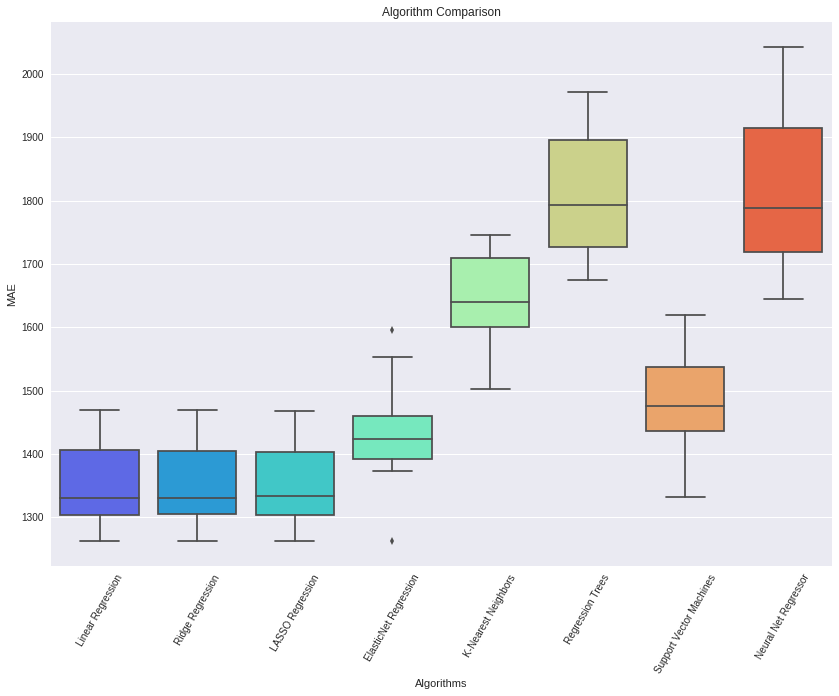

In [248]:
result = run_ML_pipeline(X, y)

In [73]:
ML_results = pd.concat([result], keys=[1])

In [74]:
ML_results.index.names = ['Iter', 'Algorithm']

In [75]:
ML_results

MAE           MSE         RMSE
Iter Algorithm                                                      
1    Linear Regression        1351.345176  3.117638e+06  1765.683543
     Ridge Regression         1351.280469  3.117158e+06  1765.547603
     LASSO Regression         1350.282598  3.113490e+06  1764.508409
     ElasticNet Regression    1432.420393  3.506436e+06  1872.548015
     K-Nearest Neighbors      1644.415798  4.545081e+06  2131.919613
     Regression Trees         1810.901613  5.954072e+06  2440.096624
     Support Vector Machines  1478.748367  3.930339e+06  1982.508315
     Neural Net Regressor     1817.492644  5.455569e+06  2335.715952

### #2 features selected:
- dow
- actual_time
- stores

In [76]:
X = matrix[['actual_time', 'dow_1','dow_2', 'dow_3', 
            'dow_4', 'dow_5', 'dow_6', 'store_1', 'store_2', 'store_3', 
            'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 
            'store_9', 'store_10', 'store_11', 'store_12', 'store_13', 
            'store_14', 'store_15', 'store_16', 'store_17']]
y = matrix['total_time']

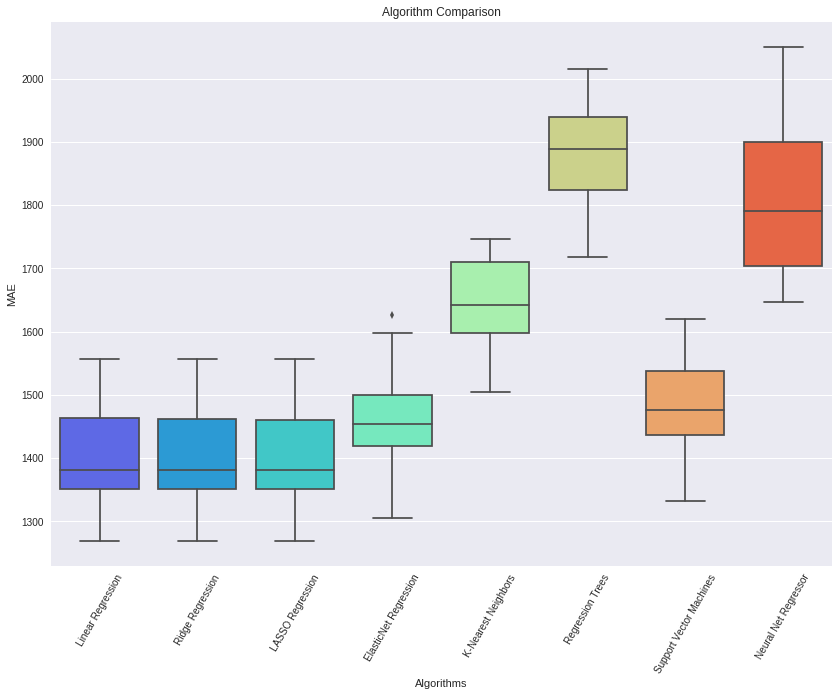

In [77]:
result = run_ML_pipeline(X, y)

In [78]:
result = pd.concat([result], keys=[2])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
2 Linear Regression        1403.241275  3.370805e+06  1835.975205
  Ridge Regression         1402.811557  3.369939e+06  1835.739418
  LASSO Regression         1401.373206  3.365327e+06  1834.482840
  ElasticNet Regression    1467.944929  3.665019e+06  1914.423839
  K-Nearest Neighbors      1644.456248  4.546770e+06  2132.315633
  Regression Trees         1881.560791  6.334113e+06  2516.766304
  Support Vector Machines  1478.750641  3.930352e+06  1982.511528
  Neural Net Regressor     1810.328677  5.478302e+06  2340.577232

### #3 features selected:
- dow
- on_demand
- actual_time
- quantity_products
- stores

In [79]:
X = matrix[['actual_time', 'dow_1','dow_2', 'dow_3', 
            'dow_4', 'dow_5', 'dow_6', 'store_1', 'store_2', 'store_3', 
            'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 
            'store_9', 'store_10', 'store_11', 'store_12', 'store_13', 
            'store_14', 'store_15', 'store_16', 'store_17', 
            'on_demand', 'quantity_products']]
y = matrix['total_time']

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


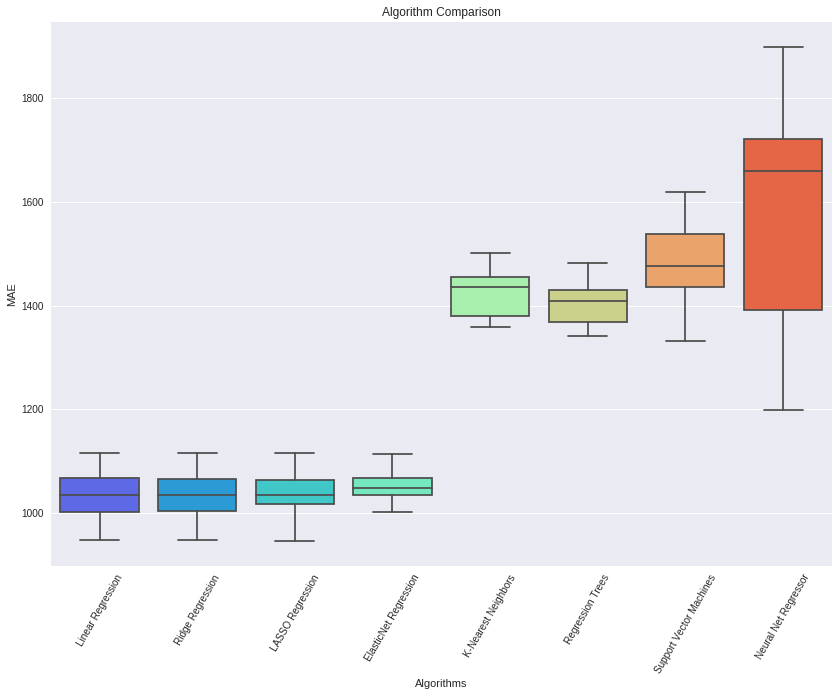

In [80]:
result = run_ML_pipeline(X, y)

In [81]:
result = pd.concat([result], keys=[3])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
3 Linear Regression        1034.894041  1.794459e+06  1339.574245
  Ridge Regression         1034.941039  1.794082e+06  1339.433289
  LASSO Regression         1036.808292  1.796780e+06  1340.440366
  ElasticNet Regression    1053.414396  1.862068e+06  1364.576259
  K-Nearest Neighbors      1428.502472  3.552362e+06  1884.770942
  Regression Trees         1403.925824  3.397778e+06  1843.306226
  Support Vector Machines  1478.753783  3.930320e+06  1982.503418
  Neural Net Regressor     1579.772372  3.974744e+06  1993.675910

### #4 features selected:
- dow
- on_demand
- actual_time
- quantity_products
- sum_products
- stores

In [82]:
X = matrix[['actual_time', 'dow_1','dow_2', 'dow_3', 
            'dow_4', 'dow_5', 'dow_6', 'store_1', 'store_2', 'store_3', 
            'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 
            'store_9', 'store_10', 'store_11', 'store_12', 'store_13', 
            'store_14', 'store_15', 'store_16', 'store_17', 
            'on_demand', 'quantity_products', 'sum_products']]
y = matrix['total_time']

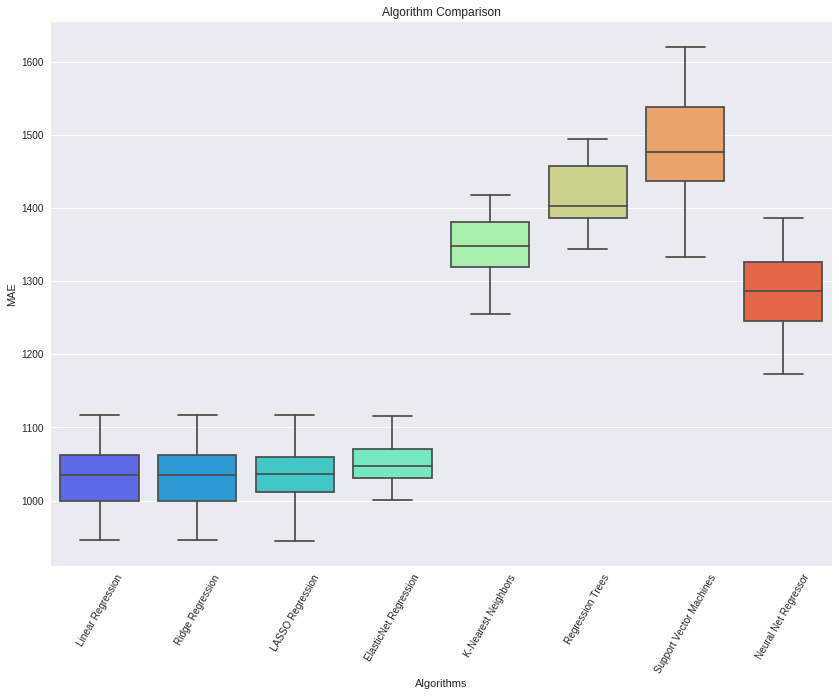

In [83]:
result = run_ML_pipeline(X, y)

In [84]:
result = pd.concat([result], keys=[4])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
4 Linear Regression        1033.132709  1.790271e+06  1338.010262
  Ridge Regression         1033.164722  1.789885e+06  1337.865653
  LASSO Regression         1035.024517  1.792616e+06  1338.886014
  ElasticNet Regression    1051.104258  1.857471e+06  1362.890649
  K-Nearest Neighbors      1345.737026  3.166656e+06  1779.510123
  Regression Trees         1416.440774  3.567787e+06  1888.858526
  Support Vector Machines  1478.782550  3.930449e+06  1982.535891
  Neural Net Regressor     1289.751302  2.717406e+06  1648.455662

### #5 features selected:
- dow
- on_demand
- actual_time
- quantity_products
- sum_products

In [85]:
X = matrix[['actual_time', 'dow_1','dow_2', 'dow_3', 
            'dow_4', 'dow_5', 'dow_6', 'sum_products',
            'on_demand', 'quantity_products']]
y = matrix['total_time']

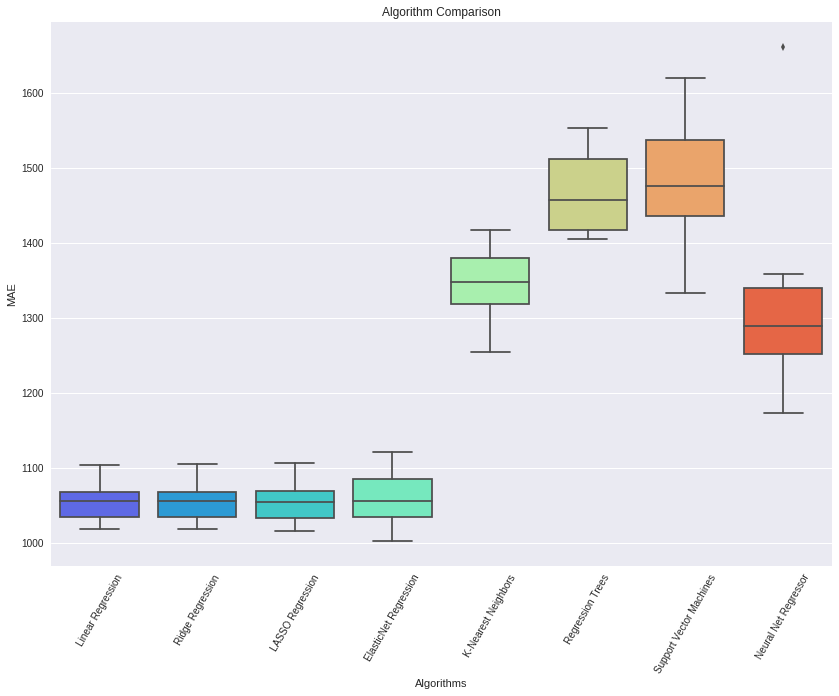

In [86]:
result = run_ML_pipeline(X, y)

In [87]:
result = pd.concat([result], keys=[5])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
5 Linear Regression        1056.514957  1.866106e+06  1366.054775
  Ridge Regression         1056.500856  1.866076e+06  1366.043954
  LASSO Regression         1056.595085  1.866524e+06  1366.208067
  ElasticNet Regression    1062.018603  1.894601e+06  1376.445046
  K-Nearest Neighbors      1345.831351  3.166728e+06  1779.530177
  Regression Trees         1465.476711  3.732113e+06  1931.867762
  Support Vector Machines  1478.803432  3.930517e+06  1982.553132
  Neural Net Regressor     1316.305040  2.682405e+06  1637.804875

##### Apparently, non-linear models have lagged behind in performance. 

### #6 features selected:
- promised_time
- dow
- on_demand
- actual_time
- quantity_products
- sum_products
- picker_rating
- driver_rating
- picker_seniority
- driver_seniority

In [88]:
X = matrix[['promised_time', 'on_demand', 'quantity_products', 'sum_products',
       'picker_rating', 'driver_rating', 'actual_time',
       'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review']]
y = matrix['total_time']

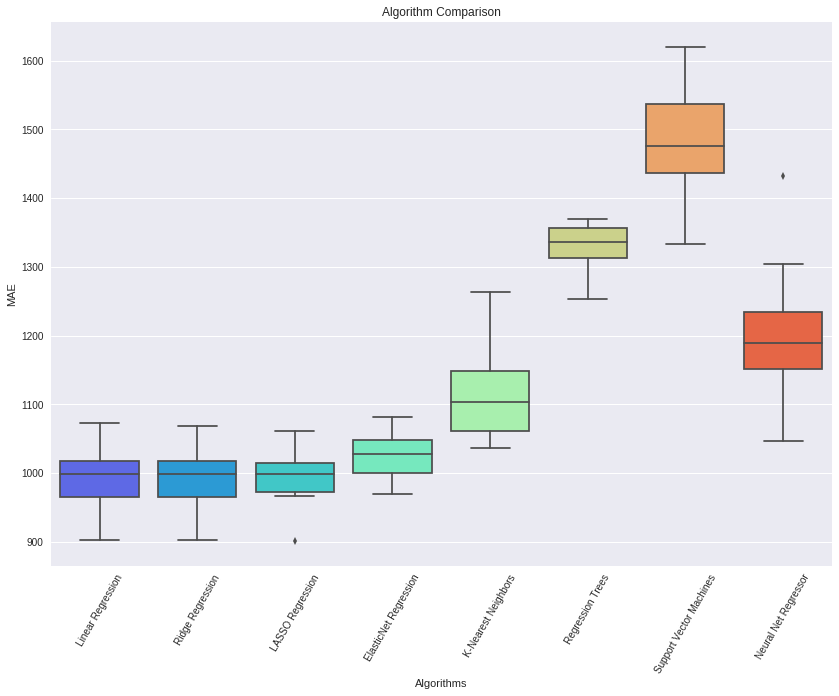

In [89]:
result = run_ML_pipeline(X, y)

In [90]:
result = pd.concat([result], keys=[6])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
6 Linear Regression         995.426004  1.701339e+06  1304.353735
  Ridge Regression          994.846814  1.698451e+06  1303.246414
  LASSO Regression          995.901536  1.701062e+06  1304.247731
  ElasticNet Regression    1026.892592  1.809173e+06  1345.054963
  K-Nearest Neighbors      1117.095274  2.332775e+06  1527.342525
  Regression Trees         1328.524173  3.018768e+06  1737.460355
  Support Vector Machines  1478.795566  3.930452e+06  1982.536876
  Neural Net Regressor     1202.726535  2.148741e+06  1465.858431

### #7 features selected:
- promised_time
- dow
- on_demand
- actual_time
- quantity_products
- picker_rating
- driver_rating
- picker_seniority
- driver_seniority

In [91]:
X = matrix[['promised_time', 'on_demand', 'quantity_products',
       'picker_rating', 'driver_rating', 'actual_time',
       'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review']]
y = matrix['total_time']

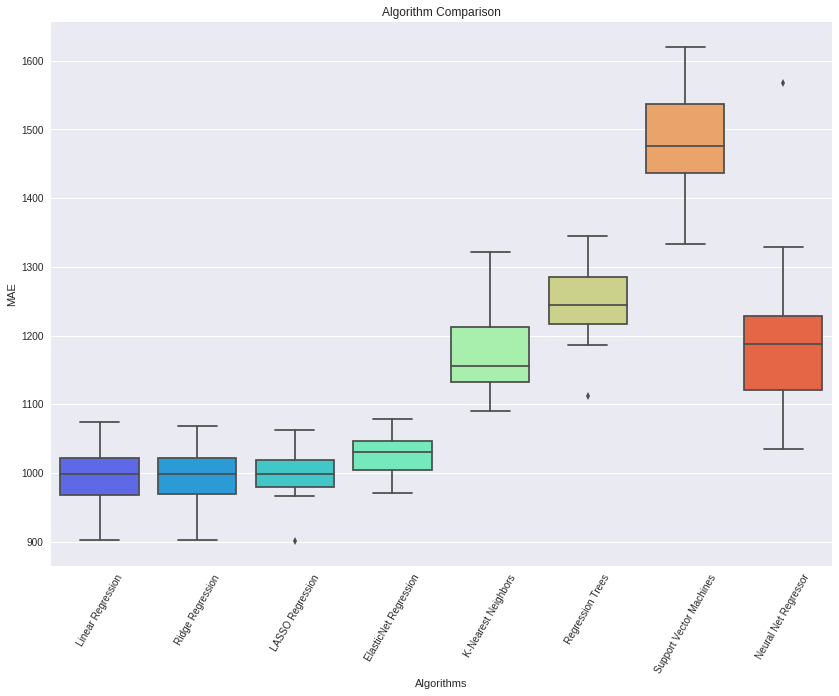

In [92]:
result = run_ML_pipeline(X, y)

In [93]:
result = pd.concat([result], keys=[7])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
7 Linear Regression         997.169854  1.705748e+06  1306.042689
  Ridge Regression          996.608617  1.702899e+06  1304.951909
  LASSO Regression          997.505660  1.705330e+06  1305.882698
  ElasticNet Regression    1028.936348  1.813755e+06  1346.757305
  K-Nearest Neighbors      1178.755211  2.557679e+06  1599.274670
  Regression Trees         1244.072014  2.779114e+06  1667.067483
  Support Vector Machines  1478.781643  3.930394e+06  1982.522074
  Neural Net Regressor     1206.726292  3.604891e+06  1898.655159

### #8 features selected:
- dow
- on_demand
- actual_time
- quantity_products
- picker_rating
- driver_rating
- picker_seniority
- driver_seniority

In [94]:
X = matrix[['driver_review', 'on_demand', 'quantity_products',
       'picker_rating', 'driver_rating', 'actual_time',
       'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate']]
y = matrix['total_time']

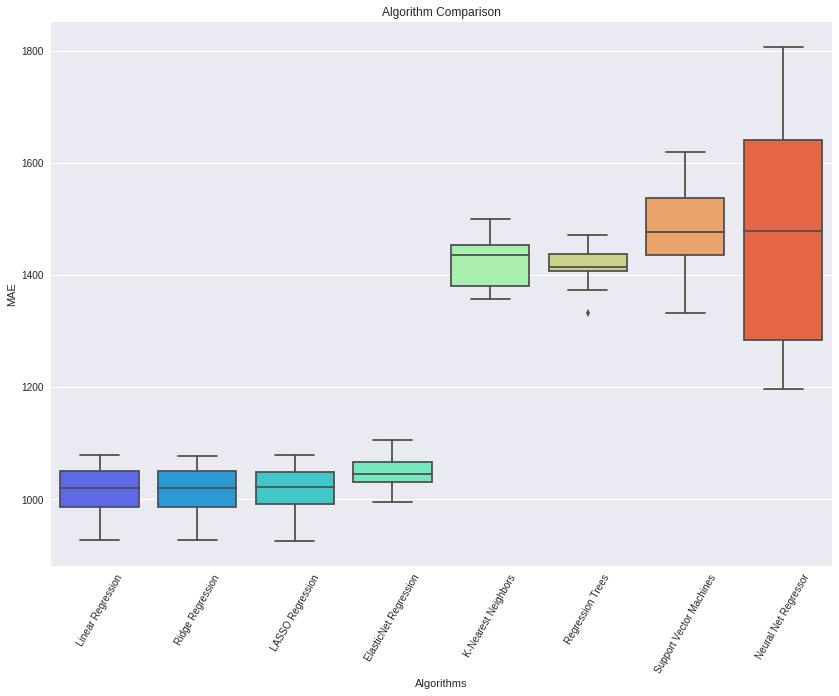

In [95]:
result = run_ML_pipeline(X, y)

In [96]:
result = pd.concat([result], keys=[8])
ML_results = pd.concat([ML_results, result])
result

MAE           MSE         RMSE
8 Linear Regression        1017.743191  1.736430e+06  1317.736675
  Ridge Regression         1017.203695  1.733555e+06  1316.645404
  LASSO Regression         1018.266531  1.735844e+06  1317.514366
  ElasticNet Regression    1048.018653  1.843618e+06  1357.799030
  K-Nearest Neighbors      1428.412828  3.552573e+06  1884.827090
  Regression Trees         1415.764963  3.444023e+06  1855.807826
  Support Vector Machines  1478.739674  3.930252e+06  1982.486205
  Neural Net Regressor     1468.079182  3.392218e+06  1841.797422

### Global Results

In [303]:
ML_results

MAE           MSE         RMSE
Iter Algorithm                                                      
1    Linear Regression        1351.345176  3.117638e+06  1765.683543
     Ridge Regression         1351.280469  3.117158e+06  1765.547603
     LASSO Regression         1350.282598  3.113490e+06  1764.508409
     ElasticNet Regression    1432.420393  3.506436e+06  1872.548015
     K-Nearest Neighbors      1644.415798  4.545081e+06  2131.919613
     Regression Trees         1810.901613  5.954072e+06  2440.096624
     Support Vector Machines  1478.748367  3.930339e+06  1982.508315
     Neural Net Regressor     1817.492644  5.455569e+06  2335.715952
2    Linear Regression        1403.241275  3.370805e+06  1835.975205
     Ridge Regression         1402.811557  3.369939e+06  1835.739418
     LASSO Regression         1401.373206  3.365327e+06  1834.482840
     ElasticNet Regression    1467.944929  3.665019e+06  1914.423839
     K-Nearest Neighbors      1644.456248  4.546770e+06  2132.315633
     Regression Trees         1881.560791  6.334113e+06  2516.766304
     Support Vector Machines  1478.750641  3.930352e+06  1982.511528
     Neural Net Regressor     1810.328677  5.478302e+06  2340.577232
3    Linear Regression        1034.894041  1.794459e+06  1339.574245
     Ridge Regression         1034.941039  1.794082e+06  1339.433289
     LASSO Regression         1036.808292  1.796780e+06  1340.440366
     ElasticNet Regression    1053.414396  1.862068e+06  1364.576259
     K-Nearest Neighbors      1428.502472  3.552362e+06  1884.770942
     Regression Trees         1403.925824  3.397778e+06  1843.306226
     Support Vector Machines  1478.753783  3.930320e+06  1982.503418
     Neural Net Regressor     1579.772372  3.974744e+06  1993.675910
4    Linear Regression        1033.132709  1.790271e+06  1338.010262
     Ridge Regression         1033.164722  1.789885e+06  1337.865653
     LASSO Regression         1035.024517  1.792616e+06  1338.886014
     ElasticNet Regression    1051.104258  1.857471e+06  1362.890649
     K-Nearest Neighbors      1345.737026  3.166656e+06  1779.510123
     Regression Trees         1416.440774  3.567787e+06  1888.858526
...                                   ...           ...          ...
5    LASSO Regression         1056.595085  1.866524e+06  1366.208067
     ElasticNet Regression    1062.018603  1.894601e+06  1376.445046
     K-Nearest Neighbors      1345.831351  3.166728e+06  1779.530177
     Regression Trees         1465.476711  3.732113e+06  1931.867762
     Support Vector Machines  1478.803432  3.930517e+06  1982.553132
     Neural Net Regressor     1316.305040  2.682405e+06  1637.804875
6    Linear Regression         995.426004  1.701339e+06  1304.353735
     Ridge Regression          994.846814  1.698451e+06  1303.246414
     LASSO Regression          995.901536  1.701062e+06  1304.247731
     ElasticNet Regression    1026.892592  1.809173e+06  1345.054963
     K-Nearest Neighbors      1117.095274  2.332775e+06  1527.342525
     Regression Trees         1328.524173  3.018768e+06  1737.460355
     Support Vector Machines  1478.795566  3.930452e+06  1982.536876
     Neural Net Regressor     1202.726535  2.148741e+06  1465.858431
7    Linear Regression         997.169854  1.705748e+06  1306.042689
     Ridge Regression          996.608617  1.702899e+06  1304.951909
     LASSO Regression          997.505660  1.705330e+06  1305.882698
     ElasticNet Regression    1028.936348  1.813755e+06  1346.757305
     K-Nearest Neighbors      1178.755211  2.557679e+06  1599.274670
     Regression Trees         1244.072014  2.779114e+06  1667.067483
     Support Vector Machines  1478.781643  3.930394e+06  1982.522074
     Neural Net Regressor     1206.726292  3.604891e+06  1898.655159
8    Linear Regression        1017.743191  1.736430e+06  1317.736675
     Ridge Regression         1017.203695  1.733555e+06  1316.645404
     LASSO Regression         1018.266531  1.735844e+06  1317.514366
     ElasticNet Regression    1048.0

### What are the best results?

In [101]:
ML_results.loc[ML_results['RMSE'].idxmin()]

MAE     9.948468e+02
MSE     1.698451e+06
RMSE    1.303246e+03
Name: (6, Ridge Regression), dtype: float64

### What are the worst results?

In [103]:
ML_results.loc[ML_results['RMSE'].idxmax()]

MAE     1.881561e+03
MSE     6.334113e+06
RMSE    2.516766e+03
Name: (2, Regression Trees), dtype: float64

### Predictions

In [249]:
from sklearn.model_selection import train_test_split

In [298]:
## Here are features chosen in the #6 iteration
X = matrix[['promised_time', 'on_demand', 'quantity_products', 'sum_products',
       'picker_rating', 'driver_rating', 'actual_time',
       'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review']]
y = matrix['total_time']

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
ridge_model = Ridge()
ridge_model.fit(X_train,y_train)
predictions = ridge_model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


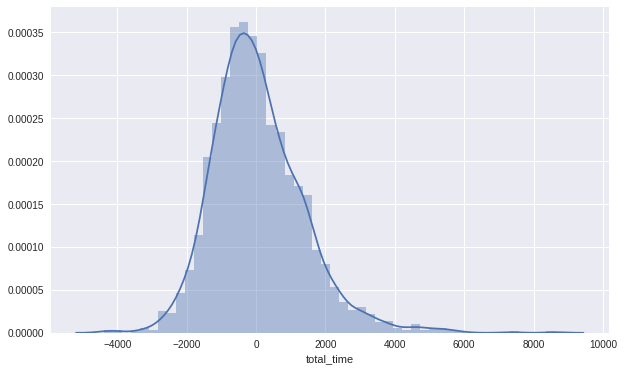

In [301]:
plt.figure(figsize=(10, 6))
sns.distplot((y_test-predictions),bins=50);

This diagram indicates that the chosen model was correct.

In [254]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 997.411404333
MSE: 1748355.18304
RMSE: 1322.25382701


### Completing dataset with the predictions.

In [259]:
## Here are features chosen in the #6 iteration
X = matrix_tocomplete[['promised_time', 'on_demand', 'quantity_products', 'sum_products',
       'picker_rating', 'driver_rating', 'actual_time',
       'store_1', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6',
       'store_7', 'store_8', 'store_9', 'store_10', 'store_11', 'store_12',
       'store_13', 'store_14', 'store_15', 'store_16', 'store_17', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'picker_beginner',
       'picker_intermediate', 'picker_review', 'driver_beginner',
       'driver_intermediate', 'driver_review']]

In [260]:
predictions = ridge_model.predict(X)

In [262]:
matrix_tocomplete['total_time'] = predictions

In [269]:
# Convert seconds to minutes
matrix_tocomplete['total_minutes'] = matrix_tocomplete['total_time'].apply(lambda x: x/60)

In [293]:
import datetime

In [292]:
# Convert seconds to hhmmss
matrix_tocomplete['promised_time'] = matrix_tocomplete['promised_time'].apply(
    lambda x: str(datetime.timedelta(seconds=x)))

In [294]:
matrix_tocomplete['actual_time'] = matrix_tocomplete['actual_time'].apply(
    lambda x: str(datetime.timedelta(seconds=x)))

## Predictions for empty data (total_minutes) 

In [296]:
matrix_tocomplete[['promised_time', 'actual_time', 'total_minutes']]

,promised_time,actual_time,total_minutes
539,11:47:00,11:14:07,90.307466
540,14:00:00,12:57:54,85.753134
541,16:21:00,15:45:23,87.353186
542,17:05:00,16:58:47,92.192552
543,14:00:00,12:57:43,67.584309
544,16:00:00,15:19:22,141.018540
545,11:00:00,10:07:25,77.910372
546,14:35:00,13:56:41,57.384387
547,19:00:00,18:22:06,105.392114
548,19:00:00,17:58:06,102.036571


# By Nicolás Venegas Oliva <nvenegas.oliva@gmail.com\>